<a href="https://colab.research.google.com/github/Nawa-Punabantu/Opt_Algos/blob/main/ParEGO_EI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
from scipy.stats import norm




In [22]:

# --- Define KNO1 objective functions ---
def compute_r(x1, x2):

    term1 = 3 * np.sin(5 / (2 * (x1 + x2)**2))
    term2 = 3 * np.sin(4 * (x1 + x2))
    term3 = 5 * np.sin(2 * (x1 + x2) + 2)
    return 9 - (term1 + term2 + term3)

def compute_phi(x1, x2):
    return np.pi / (12 * (x1 - x2 + 3))

def kno1_f1(x):
    epsilon = 1e-8
    x+=epsilon
    r = compute_r(x[0], x[1])
    phi = compute_phi(x[0], x[1])
    return 20 - r * np.cos(phi)

def kno1_f2(x):
    epsilon = 1e-8
    x+=epsilon
    r = compute_r(x[0], x[1])
    phi = compute_phi(x[0], x[1])
    return 20 - r * np.sin(phi)

# --- Surrogate model creation ---
def surrogate_model(X_train, y_train):
    kernel = C(1.0, (1e-4, 10.0)) * RBF(1.0, (1e-4, 10.0))
    gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, normalize_y=True, n_restarts_optimizer=5)
    gp.fit(X_train, y_train)
    return gp

# --- Scalarized surrogate objective for ParEGO ---

def scalarized_surrogate_objective(x, surrogate_f1, surrogate_f2, weights):
    """
    outputs a scalar given the scalar fromed from the inputs
    the candidated point [x] is evaluated at the surrogate_f1 & surrogate_f2

    and the value of the Tchebycheb at x is then evaluated

    this is the form expected by the, differential_evolution function since
    we are directly optimizaing the Tchebychev function and not the EI

    """

    f1_pred = surrogate_f1.predict([x])[0]
    f2_pred = surrogate_f2.predict([x])[0]

    # Tchebycheff scalarization
    scalar_value = max(weights[0] * f1_pred, weights[1] * f2_pred)

    # Add nonlinear augmentation (optional, per ParEGO paper)
    phi = 0.05
    scalar_value += phi * (weights[0] * f1_pred + weights[1] * f2_pred)

    return scalar_value

# --- AQ func: Expected Improvement ---
def expected_improvement(x, surrogate_f1, surrogate_f2, weights, y_best):
    """
    Computes the Expected Improvement at a point x.
    Scalarizes the surrogate predictions using Tchebycheff, then computes EI.
    """
    x = np.array(x).reshape(1, -1)

    mu_f1, sigma_f1 = surrogate_f1.predict(x, return_std=True)
    mu_f2, sigma_f2 = surrogate_f2.predict(x, return_std=True)

    mu_scalar = np.maximum(weights[0] * mu_f1, weights[1] * mu_f2)
    phi = 0.05
    mu_scalar += phi * (weights[0] * mu_f1 + weights[1] * mu_f2)

    # Approximate variance of scalarized objective
    sigma_scalar = np.sqrt(weights[0]**2 * sigma_f1**2 + weights[1]**2 * sigma_f2**2)

    # Compute EI
    with np.errstate(divide='warn'):
        Z = (y_best - mu_scalar) / sigma_scalar
        ei = (y_best - mu_scalar) * norm.cdf(Z) + sigma_scalar * norm.pdf(Z)
        ei[sigma_scalar == 0.0] = 0.0

    return -ei[0]  # Negative for minimization


# --- Initialize random population ---
def initialize_population(pop_size, bounds):
    """
    outputs a matrix of mxn, where:
    m => number of (random) samples
    n => sampled values of the nth variable, we have 2 vars here so; mx2.

    This is where we would place a latin hypercube routine
    to select initial points

    Note that each row, correspondes to 1 scalar point for each objective


    """
    return np.random.uniform(bounds[:, 0], bounds[:, 1], (pop_size, bounds.shape[0]))

# --- Update Pareto front ---
def update_pareto_front(pop, f1_vals, f2_vals):
    pareto = []
    for i in range(len(pop)):
        dominated = False
        for j in range(len(pop)):
            if (f1_vals[j] <= f1_vals[i] and f2_vals[j] <= f2_vals[i]) and (f1_vals[j] < f1_vals[i] or f2_vals[j] < f2_vals[i]):
                dominated = True
                break
        if not dominated:
            pareto.append([f1_vals[i], f2_vals[i]])
    return np.array(pareto)

# --- ParEGO Main Loop ---
def par_ego(num_generations, pop_size, bounds):
    population = initialize_population(pop_size, bounds)

    f1_vals = np.array([kno1_f1(p) for p in population])
    f2_vals = np.array([kno1_f2(p) for p in population])
    # Note that: kno1_f2(p) for p in population loops through each row
    # Each row is a sample. If we have m rows, the length of f1_vals and
    # f2_vals, is m.

    # Initialize where we will store solutions
    pareto_all = []

    for gen in range(num_generations):
        # generation = iteration

        # Train surrogate models
        # Note that for 2d x vals, surrogate_f1 and surrogate_f2
        # are 3d surfaces
        surrogate_f1 = surrogate_model(population, f1_vals)
        surrogate_f2 = surrogate_model(population, f2_vals)
        # Note that for 2d x vals, surrogate_f1 and surrogate_f2
        # are 3d surfaces

        # Generate random weights for scalarization
        lam = np.random.rand()
        weights = [lam, 1 - lam]
        # Note that we generate new weights in each iteration/generation
        # i.e. each time we update the training set

        # Scalarized function value of current best point
        phi = 0.05
        f1_preds = surrogate_f1.predict(population)
        f2_preds = surrogate_f2.predict(population)
        scalar_preds = np.maximum(weights[0] * f1_preds, weights[1] * f2_preds)
        scalar_preds += phi * (weights[0] * f1_preds + weights[1] * f2_preds)
        y_best = np.min(scalar_preds)

        # Optimize EI instead of Tchebycheff directly
        result = differential_evolution(
            expected_improvement,
            bounds=bounds,
            args=(surrogate_f1, surrogate_f2, weights, y_best),
            maxiter=20,
            popsize=10,
            seed=42,
            disp=False
        )

        x_new = result.x
        f1_new = kno1_f1(x_new)
        f2_new = kno1_f2(x_new)

        # Add to population
        population = np.vstack((population, x_new))
        f1_vals = np.append(f1_vals, f1_new)
        f2_vals = np.append(f2_vals, f2_new)

        # Store current pareto
        pareto = update_pareto_front(population, f1_vals, f2_vals)
        pareto_all.append(pareto)

        print(f"Gen {gen+1} | New f1: {f1_new:.4f}, f2: {f2_new:.4f}")

    return pareto_all[-1], f1_vals, f2_vals



In [18]:
bounds = np.array([[0, 3], [0, 3]])
num_generations = 50
pop_size = 5
population = np.random.uniform(bounds[:, 0], bounds[:, 1], (pop_size, bounds.shape[0]))
for p in population:
  print(p)

[1.1038253  0.88292748]
[2.76999165 1.83961177]
[2.02996834 0.20734653]
[2.29902321 0.18076327]
[0.22584157 0.06784899]


In [25]:
# --- Run ParEGO ---
bounds = np.array([[0, 3], [0, 3]])
num_generations = 50 # C iterations
pop_size = 20     # number of initial samples to draw and train the GPs on.

pareto_front, all_f1, all_f2 = par_ego(num_generations, pop_size, bounds)



Gen 1 | New f1: 6.8832, f2: 18.6020
Gen 2 | New f1: 11.0646, f2: 18.8073


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Gen 3 | New f1: 5.3655, f2: 17.7631
Gen 4 | New f1: 6.8669, f2: 18.8159
Gen 5 | New f1: 14.9877, f2: 18.0996
Gen 6 | New f1: 4.1844, f2: 17.9518
Gen 7 | New f1: 6.6339, f2: 18.6173
Gen 8 | New f1: 3.8160, f2: 17.5451
Gen 9 | New f1: 3.7757, f2: 18.4520
Gen 10 | New f1: 6.8496, f2: 18.9536
Gen 11 | New f1: 3.7488, f2: 18.2600
Gen 12 | New f1: 10.1639, f2: 19.0561
Gen 13 | New f1: 3.9799, f2: 16.8170


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Gen 14 | New f1: 4.1326, f2: 16.7581
Gen 15 | New f1: 5.0287, f2: 16.6707
Gen 16 | New f1: 4.5585, f2: 18.4434
Gen 17 | New f1: 7.5824, f2: 19.3471
Gen 18 | New f1: 8.1156, f2: 17.6301
Gen 19 | New f1: 18.0214, f2: 14.1247


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Gen 20 | New f1: 4.0446, f2: 18.6684
Gen 21 | New f1: 25.3340, f2: 18.5151
Gen 22 | New f1: 3.8623, f2: 17.9748
Gen 23 | New f1: 16.4098, f2: 19.7885
Gen 24 | New f1: 4.3828, f2: 18.8930
Gen 25 | New f1: 16.7248, f2: 19.8519
Gen 26 | New f1: 6.0521, f2: 19.1570
Gen 27 | New f1: 13.4694, f2: 19.4286
Gen 28 | New f1: 16.8294, f2: 19.7791


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Gen 29 | New f1: 4.3187, f2: 18.9293
Gen 30 | New f1: 3.9488, f2: 18.9879
Gen 31 | New f1: 17.1053, f2: 19.8221
Gen 32 | New f1: 13.6146, f2: 19.4685
Gen 33 | New f1: 14.7829, f2: 19.4076
Gen 34 | New f1: 13.5577, f2: 19.5292
Gen 35 | New f1: 3.8007, f2: 19.0686
Gen 36 | New f1: 13.9585, f2: 19.6950
Gen 37 | New f1: 10.7890, f2: 19.4730
Gen 38 | New f1: 14.6461, f2: 18.9364
Gen 39 | New f1: 14.3636, f2: 19.6665
Gen 40 | New f1: 14.2298, f2: 19.3070
Gen 41 | New f1: 13.5395, f2: 19.6626
Gen 42 | New f1: 15.6125, f2: 19.7872
Gen 43 | New f1: 6.8087, f2: 19.0181


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Gen 44 | New f1: 5.7844, f2: 18.7576
Gen 45 | New f1: 16.8702, f2: 19.6735


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Gen 46 | New f1: 4.0125, f2: 18.8017
Gen 47 | New f1: 13.1211, f2: 19.2986
Gen 48 | New f1: 7.0574, f2: 17.8811
Gen 49 | New f1: 8.1140, f2: 19.1559
Gen 50 | New f1: 3.6467, f2: 19.0081


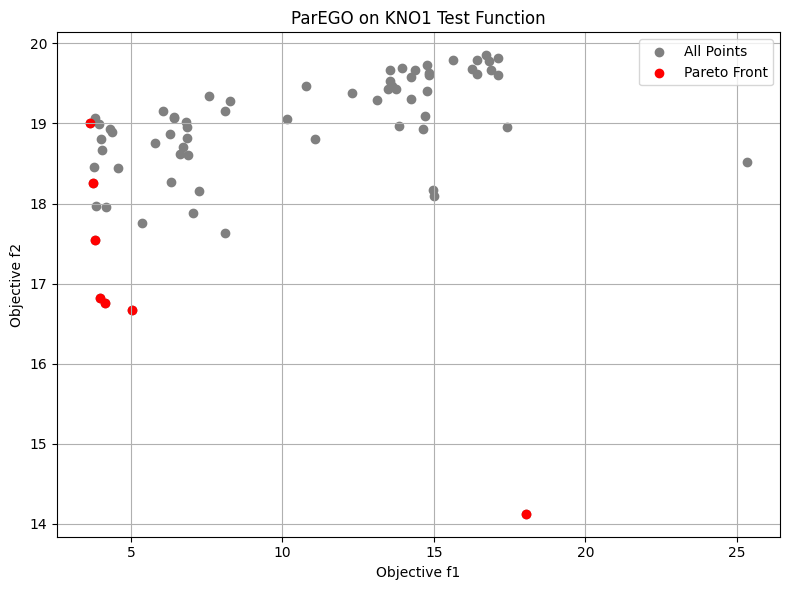

In [26]:
# --- Plot Results ---
plt.figure(figsize=(8, 6))
plt.scatter(all_f1, all_f2, c='gray', label="All Points")
plt.scatter(pareto_front[:, 0], pareto_front[:, 1], c='red', label="Pareto Front")
plt.xlabel("Objective f1")
plt.ylabel("Objective f2")
plt.title("ParEGO on KNO1 Test Function")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()